# Comparison of `protons` with instant and NCMC exchanges
Notebook to explore the  `protons` calibration of tyrosine in **implicit** solvent. Comparing **instant** protonation state exchanges with **NCMC** exchanges. The NCMC implementation should replicate the numerics of the instant swaps.

In [1]:
from __future__ import print_function
from simtk import unit, openmm
from simtk.openmm import app
from protons import AmberProtonDrive
from protons.calibration import SelfAdjustedMixtureSampling, AmberCalibrationSystem
import openmmtools
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

## Function designed to run both types of simulation

In [2]:
def prepare_system(prmtop, inpcrd, cpin, pH = 7.0, platform='CPU', nsteps=0, implicit=True):
    """
    Function to prepare a system specified by AMBER topology files for a constant-ph calibration simulation with protons.
    Calibration is performed with self adjusted mixture sampling (SAMS).

    Parameters
    ----------
    prmtop: str
        the name of the AMBER prmtop file
    inpcrd: str
        the name of the AMBER inpcrd file
    cpin: str
        the name of the AMBER cpin file
    pH: float
        the pH at which the calibration will be performed
    platform: str
        OpenMM platform with which the simulation will be performed. Choices are 'CPU' or 'OpenCL'
    nsteps: int
        The number of NCMC steps to perform for proton creation/annihilation. If nstesp=0, instant exchanges will be done.
    implicit: bool
        Whether to calibrated in implicit or explicit solvent

    Return
    ------
    simulation: simtk.openmm.Simulation
        OpenMM simulation object
    driver: protons.AmberProtonDrive
        Driver for constant pH simulation
    sams_sampler: protons.SelfAdjustedMixtureSampling
        Wrapper for calibrating with SAMS
    integrator:  simtk.openmm.integrator
        Integrator for sampling the configuration of the system
    """
    # Loading system and initializing driver
    temperature = 300.0*unit.kelvin
    prmtop = app.AmberPrmtopFile(prmtop)
    inpcrd = app.AmberInpcrdFile(inpcrd)
    positions = inpcrd.getPositions()
    topology = prmtop.topology
    # Create system
    if implicit == True:
        system = prmtop.createSystem(implicitSolvent=app.OBC2, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)
    else:
        system = prmtop.createSystem(nonbondedMethod=app.PME, constraints=app.HBonds)
        system.addForce(openmm.MonteCarloBarostat(1*unit.atmospheres, temperature, 25))
    # Create protons integrator
    integrator = openmmtools.integrators.GHMCIntegrator(temperature, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    # Create protons proton driver
    driver = AmberProtonDrive(system, temperature, pH, prmtop, cpin, integrator, debug=False,
                              pressure=None, ncmc_steps_per_trial=nsteps, implicit=implicit)
    # Create SAMS sampler
    sams_sampler = SelfAdjustedMixtureSampling(driver)
    # Create simulation
    if platform == 'OpenCL':
        platform = openmm.Platform.getPlatformByName('OpenCL')
        properties = {'OpenCLPrecision': 'mixed'}
        simulation = app.Simulation(topology, system, driver.compound_integrator, platform, properties)
    else:
        simulation = app.Simulation(topology, system, driver.compound_integrator)
    simulation.context.setPositions(positions)
    simulation.context.setVelocitiesToTemperature(temperature)
    return simulation, driver, sams_sampler, integrator

### Instant exchanges
The SAMS weight fluctuates as expect about its converged value.

SAMS Weights = [   0.          106.95129917]


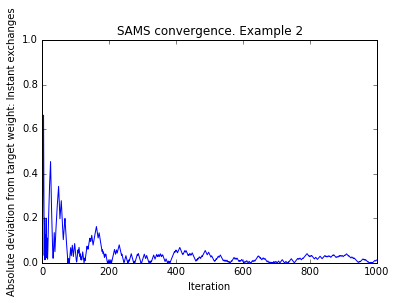

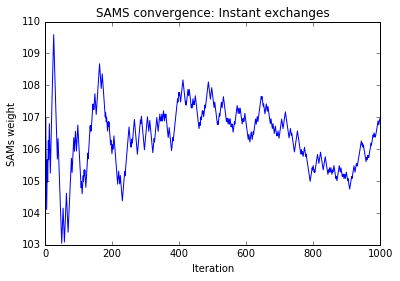

In [3]:
simulation, driver, sams_sampler, integrator = prepare_system('tyr_implicit.prmtop','tyr_implicit.inpcrd','tyr_implicit.cpin', 
                                                              platform='CPU', nsteps=0)
simulation.minimizeEnergy(maxIterations=1000)

# Initializing the weights for TYR with the approximately converged result.
g_initial = {'tyr':[  0.        ,  107.0]}
driver.import_gk_values(g_initial)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 1000
for i in range(N):
    # MD/MC
    driver.compound_integrator.setCurrentIntegrator(0)
    driver.compound_integrator.step(10)
    driver.compound_integrator.setCurrentIntegrator(1)
    # SAMS adaptation
    sams_sampler.driver.update(simulation.context)  # protonation
    # Saving data
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', stage='burn-in', b=0.5, end_of_burnin=int(N/3)))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

work_instant = [w[2] for w in driver.work_history]

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Iteration')
plt.ylabel('Absolute deviation from target weight: Instant exchanges')
plt.title('SAMS convergence. Example 2')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Iteration')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence: Instant exchanges')
plt.show()

### NCMC exchanges
The plots are comparable with instant swaps, with a similar SAMS weight achieved.

SAMS Weights = [   0.          106.65100012]


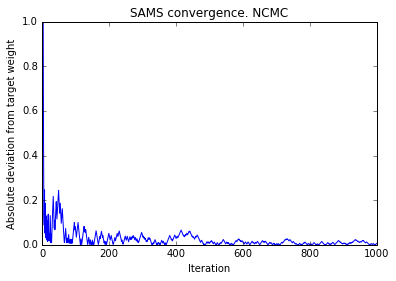

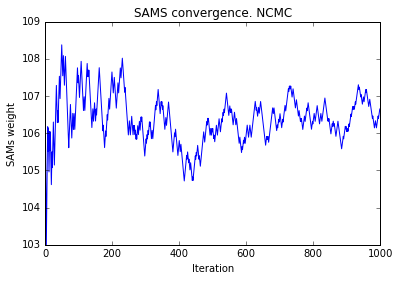

In [4]:
from simtk.openmm import XmlSerializer
from simtk.openmm.app import PDBFile

simulation, driver, sams_sampler, integrator = prepare_system('tyr_implicit.prmtop','tyr_implicit.inpcrd','tyr_implicit.cpin', 
                                                              platform='CPU', nsteps=1)
simulation.minimizeEnergy(maxIterations=1000)

# Initializing the weights for TYR with the approximately converged result.
g_initial = {'tyr':[  0.        ,  107.0]}
driver.import_gk_values(g_initial)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 1000

pdbfile = open('System_outputs/output.pdb', 'w')
PDBFile.writeHeader(simulation.topology, file=pdbfile)
positions = simulation.context.getState(getPositions=True).getPositions(asNumpy=True)
PDBFile.writeModel(simulation.topology, positions, file=pdbfile, modelIndex=0)

for i in range(N):
    # MD/MC
    driver.compound_integrator.setCurrentIntegrator(0)
    driver.compound_integrator.step(10)
    driver.compound_integrator.setCurrentIntegrator(1)
    # SAMS adaptation
    sams_sampler.driver.update(simulation.context)  # protonation
    
    # Saving system data
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', stage='burn-in', b=0.5, end_of_burnin=int(N/3)))
    weights.append(sams_sampler.get_gk())
    
    # Save coordinates
    positions = simulation.context.getState(getPositions=True).getPositions(asNumpy=True)
    PDBFile.writeModel(simulation.topology, positions, file=pdbfile, modelIndex=0)

    # Saving the system as an xml file
    serialized_system = XmlSerializer.serialize(simulation.system)
    f = open('System_outputs/system_iter{0}.xml'.format(i), 'w')
    f.write(serialized_system)
    f.close

work_ncmc = [w[2] for w in driver.work_history]    
    
print('SAMS Weights =',sams_sampler.get_gk())

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Iteration')
plt.ylabel('Absolute deviation from target weight')
plt.title('SAMS convergence. NCMC')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Iteration')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence. NCMC')
plt.show()